# A Bayesian Workflow with PyMC and ArviZ
+ [Corrie Bartelheimer: A Bayesian Workflow with PyMC and ArviZ | PyData Berlin 2019](https://www.youtube.com/watch?v=WbNmcvxRwow)
+ [Github Repository: corriebar/Bayesian-Workflow-with-PyMC](https://github.com/corriebar/Bayesian-Workflow-with-PyMC/tree/master)
+ [Slideshare: Bayesian workflow with PyMC3 and ArviZ](https://www.slideshare.net/CorrieBartelheimer/bayesian-workflow-with-pymc3-and-arviz)
+ [Kaggle Dataset: Apartment rental offers in Germany](https://www.kaggle.com/datasets/corrieaar/apartment-rental-offers-in-germany)

# 01 - Visualization and Data Exploration

In [1]:
import sys
import os
from pathlib import Path 

import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
import xarray as xr
import bambi as bmb

import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

%load_ext dotenv
%dotenv
PROJECT_DIR=Path(os.environ.get('PROJECT_DIR'))
sys.path.append(str(PROJECT_DIR))

from projects.common.berlin_housing.utils.plot_utils import set_plot_defaults, plot_price_area
from projects.common.berlin_housing.utils.data_utils import load_data

DATA_DIR = PROJECT_DIR / 'data'  / 'berlin_housing' / 'interim_data'
DATA_DIR

PosixPath('/media/david/T7/code/bmcp/bmcp-notes/data/berlin_housing/interim_data')

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

theme_set(theme_bw())
pd.set_option('display.max_columns', 100)
xr.set_options(display_expand_data=False, display_expand_attrs=False, display_expand_coords=False,
              display_expand_data_vars=False)
SEED = 1925

%load_ext watermark
%watermark --iversions

bambi     : 0.6.3
arviz     : 0.11.2
pymc3     : 3.11.4
pandas    : 1.3.2
matplotlib: 3.4.3
numpy     : 1.19.5
seaborn   : 0.11.2
sys       : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) 
[GCC 9.4.0]
xarray    : 0.19.0



In [3]:
df_orig, _, _ = load_data(kind="rents")
df_orig.head()

,zip,rent,rent_s,log_rent,log_rent_s,sqm_rent,log_sqm_rent,log_sqm_rent_s,living_space,living_space_s,offer_year,const_year,const_year_s,flattype,interior_qual,zip_code
59,12103,941.0,9.410,6.846943,-0.037463,30.354839,3.412956,2.350673,31.00,-1.145711,2019,2019.0,1.152406,NaN,NaN,84
75,14109,1399.7,13.997,7.244013,0.651780,16.999028,2.833156,0.728184,82.34,-0.002587,2019,1920.0,-0.933787,apartment,sophisticated,199
84,13086,830.0,8.300,6.721426,-0.255338,8.251317,2.110373,-1.294424,100.59,0.403763,2019,1912.0,-1.102368,ground_floor,normal,148
86,10785,3417.6,34.176,8.136694,2.201314,16.000000,2.772589,0.558695,213.60,2.920016,2019,2018.0,1.131333,penthouse,sophisticated,55
136,12057,490.0,4.900,6.194405,-1.170151,10.000000,2.302585,-0.756545,49.00,-0.744927,2019,1972.0,0.161991,apartment,normal,79


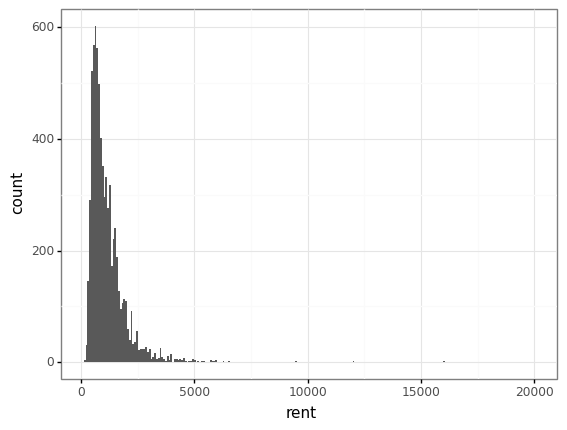

In [6]:
p = (ggplot(df_orig, aes('rent')) +
     geom_histogram(bins=250)
    )
p.draw();

+ Clearly there are some super expensive rentals that may distort the analysis
+ I will throw these out because they are most likely out of reach for normal people
+ Throw out apartments with rent > 7,500

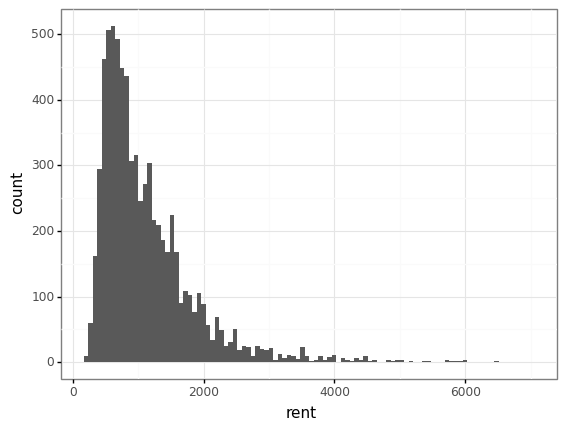

In [7]:
df = df_orig.copy()
df = df[df['rent'] < 7500]
p = (ggplot(df, aes('rent')) +
     geom_histogram(bins=100)
    )
p.draw();

In [8]:
df.describe()

,rent,rent_s,log_rent,log_rent_s,sqm_rent,log_sqm_rent,log_sqm_rent_s,living_space,living_space_s,offer_year,const_year,const_year_s,zip_code
count,7244.000000,7244.000000,7244.000000,7244.000000,7244.000000,7244.000000,7244.000000,7244.000000,7244.000000,7244.000000,6267.000000,6267.000000,7244.000000
mean,1134.802105,11.348021,6.863671,-0.008427,13.982292,2.571216,-0.004820,81.864215,-0.013181,2018.740199,1964.287538,-0.000531,97.379625
std,763.917138,7.639171,0.565856,0.982226,5.728467,0.355463,0.994715,42.592192,0.948347,0.438556,47.452646,0.999953,64.874418
min,178.160000,1.781600,5.182682,-2.926322,3.098963,1.131067,-4.034875,8.000000,-1.657823,2018.000000,1097.000000,-18.276583,0.000000
25%,630.000000,6.300000,6.445720,-0.733915,10.073513,2.309909,-0.736049,56.000000,-0.589067,2018.000000,1911.000000,-1.123441,31.000000
50%,913.830000,9.138300,6.817645,-0.088320,13.000000,2.564949,-0.022355,72.000000,-0.232815,2019.000000,1976.000000,0.246282,102.000000
75%,1409.700000,14.097000,7.251132,0.664137,16.604167,2.809654,0.662416,96.207500,0.306183,2019.000000,2012.000000,1.004897,152.000000
max,7000.000000,70.000000,8.853665,3.445848,76.250000,4.334017,4.928136,542.530000,10.243891,2019.000000,2020.000000,1.173479,210.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7244 entries, 59 to 198361
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   zip             7244 non-null   object 
 1   rent            7244 non-null   float64
 2   rent_s          7244 non-null   float64
 3   log_rent        7244 non-null   float64
 4   log_rent_s      7244 non-null   float64
 5   sqm_rent        7244 non-null   float64
 6   log_sqm_rent    7244 non-null   float64
 7   log_sqm_rent_s  7244 non-null   float64
 8   living_space    7244 non-null   float64
 9   living_space_s  7244 non-null   float64
 10  offer_year      7244 non-null   int64  
 11  const_year      6267 non-null   float64
 12  const_year_s    6267 non-null   float64
 13  flattype        6760 non-null   object 
 14  interior_qual   4378 non-null   object 
 15  zip_code        7244 non-null   int64  
dtypes: float64(11), int64(2), object(3)
memory usage: 962.1+ KB


In [10]:
df

,zip,rent,rent_s,log_rent,log_rent_s,sqm_rent,log_sqm_rent,log_sqm_rent_s,living_space,living_space_s,offer_year,const_year,const_year_s,flattype,interior_qual,zip_code
59,12103,941.00,9.4100,6.846943,-0.037463,30.354839,3.412956,2.350673,31.00,-1.145711,2019,2019.0,1.152406,NaN,NaN,84
75,14109,1399.70,13.9970,7.244013,0.651780,16.999028,2.833156,0.728184,82.34,-0.002587,2019,1920.0,-0.933787,apartment,sophisticated,199
84,13086,830.00,8.3000,6.721426,-0.255338,8.251317,2.110373,-1.294424,100.59,0.403763,2019,1912.0,-1.102368,ground_floor,normal,148
86,10785,3417.60,34.1760,8.136694,2.201314,16.000000,2.772589,0.558695,213.60,2.920016,2019,2018.0,1.131333,penthouse,sophisticated,55
136,12057,490.00,4.9000,6.194405,-1.170151,10.000000,2.302585,-0.756545,49.00,-0.744927,2019,1972.0,0.161991,apartment,normal,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198228,10997,1170.00,11.7000,7.064759,0.340627,18.465909,2.915926,0.959805,63.36,-0.425191,2019,1905.0,-1.249877,apartment,NaN,69
198281,10367,378.95,3.7895,5.937404,-1.616259,11.000000,2.397895,-0.489833,34.45,-1.068894,2018,1975.0,0.225209,apartment,NaN,19
198298,12559,579.00,5.7900,6.361302,-0.880448,9.650000,2.266958,-0.856243,60.00,-0.500004,2019,1997.0,0.688807,apartment,normal,129
198318,10557,1748.00,17.4800,7.466228,1.037504,18.400000,2.912351,0.949799,95.00,0.279297,2019,2019.0,1.152406,ground_floor,sophisticated,31


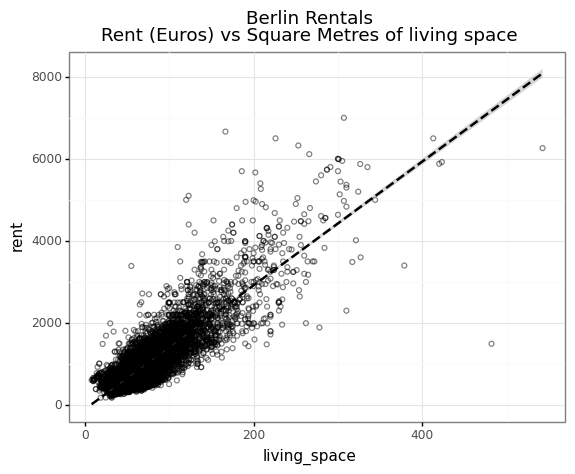

In [11]:
p = (ggplot(df, aes(x='living_space', y='rent'))+
     geom_point(fill='none', color='black', alpha=0.5) +
     geom_smooth(method='lm', linetype='dashed') +
     labs(title='Berlin Rentals\nRent (Euros) vs Square Metres of living space')
    )
p.draw();

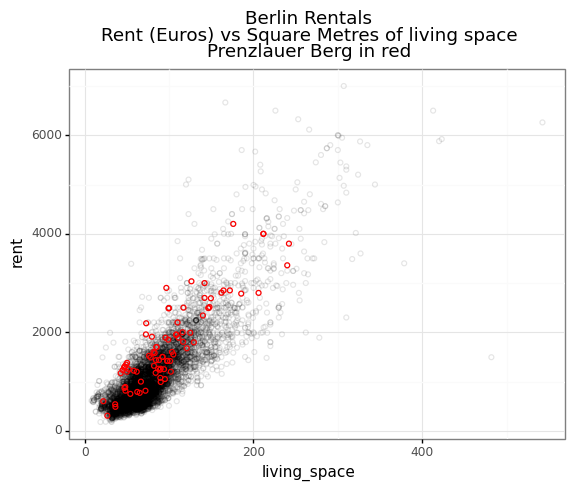

In [12]:
p = (ggplot(df, aes(x='living_space', y='rent'))+
     geom_point(fill='none', color='black', alpha=0.1) +
     geom_point(df[df['zip']=='10405'], aes(x='living_space', y='rent'), color='red', fill='none') +
     labs(title='Berlin Rentals\nRent (Euros) vs Square Metres of living space\nPrenzlauer Berg in red')
    )
p.draw();

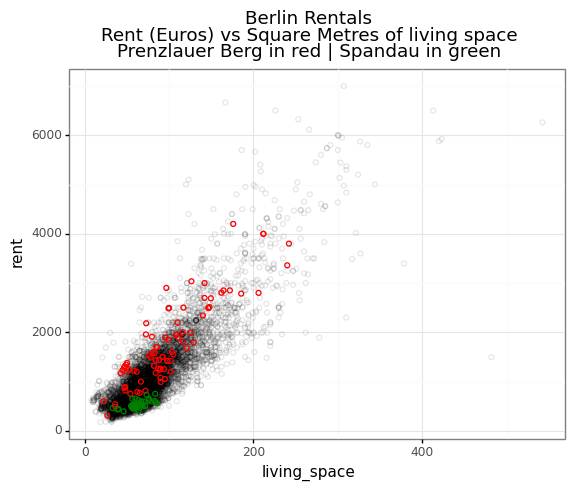

In [13]:
p = (ggplot(df, aes(x='living_space', y='rent'))+
     geom_point(fill='none', color='black', alpha=0.1) +
     geom_point(df[df['zip']=='10405'], aes(x='living_space', y='rent'), color='red', fill='none') +
     geom_point(df[df['zip']=='13583'], aes(x='living_space', y='rent'), color='green', fill='none') +
     labs(title='Berlin Rentals\nRent (Euros) vs Square Metres of living space\nPrenzlauer Berg in red | Spandau in green')
    )
p.draw();

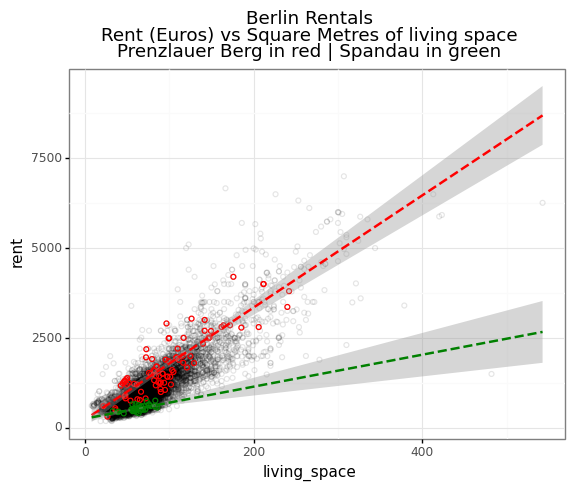

In [14]:
p = (ggplot(df, aes(x='living_space', y='rent'))+
     geom_point(fill='none', color='black', alpha=0.1) +
     geom_point(df[df['zip']=='10405'], aes(x='living_space', y='rent'), color='red', fill='none') +
     geom_smooth(df[df['zip']=='10405'], method='lm', color='red', linetype='dashed', fullrange=True) +
     geom_point(df[df['zip']=='13583'], aes(x='living_space', y='rent'), color='green', fill='none') +
     geom_smooth(df[df['zip']=='13583'], method='lm', color='green', linetype='dashed', fullrange=True) +
     labs(title='Berlin Rentals\nRent (Euros) vs Square Metres of living space\nPrenzlauer Berg in red | Spandau in green')
    )
p.draw();

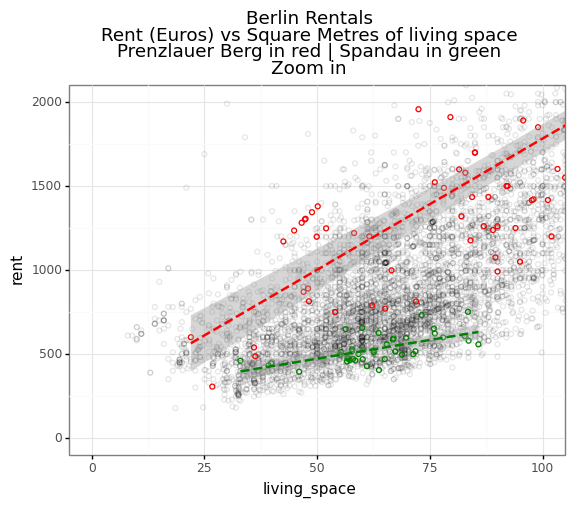

In [15]:
p = (ggplot(df, aes(x='living_space', y='rent'))+
     geom_point(fill='none', color='black', alpha=0.1) +
     geom_point(df[df['zip']=='10405'], aes(x='living_space', y='rent'), color='red', fill='none') +
     geom_smooth(df[df['zip']=='10405'], method='lm', color='red', linetype='dashed') +
     geom_point(df[df['zip']=='13583'], aes(x='living_space', y='rent'), color='green', fill='none') +
     geom_smooth(df[df['zip']=='13583'], method='lm', color='green', linetype='dashed') +
     coord_cartesian(xlim=(0, 100), ylim=(0, 2000)) +
     labs(title='Berlin Rentals\nRent (Euros) vs Square Metres of living space\nPrenzlauer Berg in red | Spandau in green\nZoom in')
    )
p.draw();

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1650: RuntimeWarning: divide by zero encountered in double_scalars


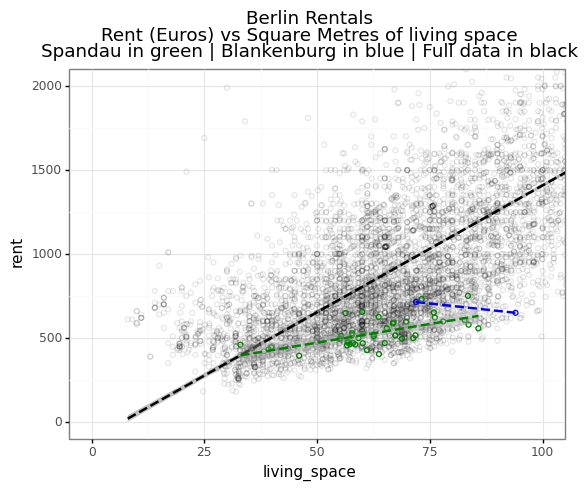

In [16]:
p = (ggplot(df, aes(x='living_space', y='rent'))+
     geom_smooth(method='lm', color='black', linetype='dashed', alpha=0.6) +
     geom_point(fill='none', color='black', alpha=0.1) +
     geom_point(df[df['zip']=='13129'], aes(x='living_space', y='rent'), color='blue', fill='none') +
     geom_smooth(df[df['zip']=='13129'], method='lm', color='blue', linetype='dashed') +
     geom_point(df[df['zip']=='13583'], aes(x='living_space', y='rent'), color='green', fill='none') +
     geom_smooth(df[df['zip']=='13583'], method='lm', color='green', linetype='dashed') +
     coord_cartesian(xlim=(0, 100), ylim=(0, 2000)) +
     labs(title='Berlin Rentals\nRent (Euros) vs Square Metres of living space\nSpandau in green | Blankenburg in blue | Full data in black')
    )
p.draw();

In [17]:
zips = df['zip'].value_counts().reset_index().rename(columns={'index': 'zip', 'zip': 'count'})
zip_list = df['zip'].value_counts().index.tolist()
zips.head()

,zip,count
0,10115,206
1,10557,195
2,10117,154
3,12627,143
4,12555,140


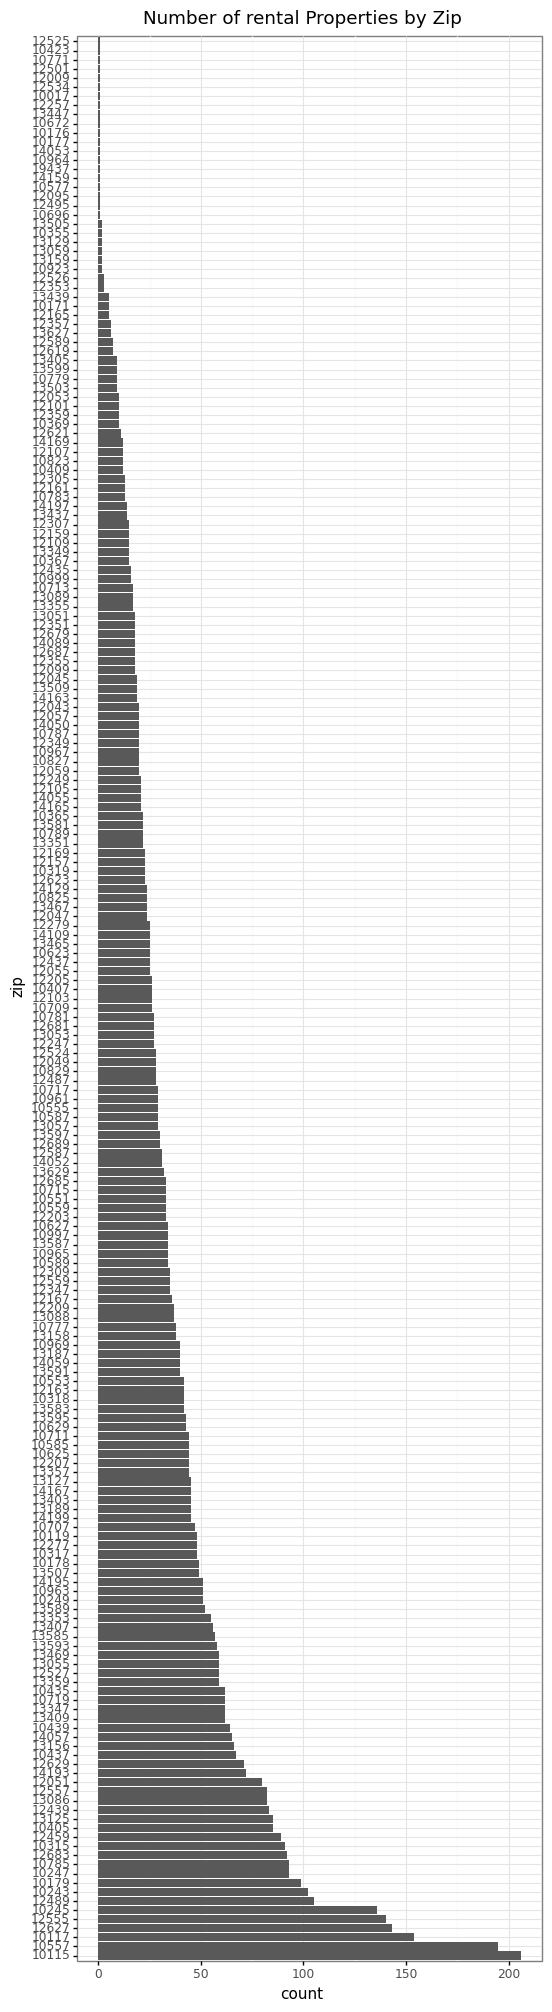

In [18]:
p = (ggplot(zips, aes(x='zip', y='count')) +
     geom_col() +
     theme(figure_size=(6,25)) +
     scale_x_discrete(limits=zip_list) +
     labs(title='Number of rental Properties by Zip') +
     coord_flip()
    )
p.draw();